In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [2]:
pwd

'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'

In [3]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\data\\valid.csv"  
TEST_PATH = dataroot + "\\data\\test.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

# test data
data_test = data_utils.CelebADataset(TEST_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [4]:
attributes = pd.read_csv('Data/list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)
test_df = matched[matched['partition']==2]

In [5]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [6]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [7]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

### Insert df:

In [8]:
df_pkl = 'run4_Gray_Hair__df.pkl'

In [9]:
# Read dataframe with training metrics
df = pd.read_pickle('models/aws_models/'+df_pkl) #e.g. pd.read_pickle('df.pkl')

In [10]:
df

,layers,activations,conv_out_channels,kernel_size,conv_stride,maxpool,dropout,batchnorm,optimizer,learning_rate,weight_decay,batch_size,num_epochs,net,train_loss,train_accs,valid_train_loss,valid_train_accs,valid_loss,valid_accs
2,2,"[<function relu at 0x000001657B103E18>, <funct...",32,5,1,2,0.2,True,Adam,0.001,0.01,128,5,run4_Gray_Hair__model2,"[0.7483529448509216, 1.4404441118240356, 0.774...","[0.4765625, 0.5, 0.59375, 0.546875, 0.6640625,...","[10.072774887084961, 0.2711810767650604, 0.251...","[0.5147228837013245, 0.8841294646263123, 0.893...",0.244498,0.899381


In [11]:
# Change i to the model number you want to load
i = 2
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

### Insert model

In [12]:
model = 'run4_Gray_Hair__model2.dms'

In [13]:
# Load network, choose the model i
net.load_state_dict(torch.load('models/aws_models/'+model,map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (l_out): Linear(in_features=11520, out_features=2, bias=False)
)

In [14]:
#dataframe for saving predictions
test_predictions = test_df.astype(object)
test_predictions.loc[:,'target'] = test_predictions.loc[:,'Smiling']
test_predictions.drop(['Smiling','partition'],axis=1)
test_predictions['output'] = np.nan
test_predictions['labels_argmax'] = np.nan
test_predictions['accuracy'] = np.nan
test_predictions['criterion'] = np.nan

In [15]:
#calculation predictions on the validation set
batch_gen_test = DataLoader(data_test, batch_size, shuffle=True, num_workers=6)
test_1_losses,test_1_accs,test_1_lengths,test_0_losses,test_0_accs,test_0_lengths = 0, 0, 0, 0, 0, 0
test_predictions = test_predictions.astype(object)
j=0
with torch.no_grad():
    for batch_test in batch_gen_test:
        
        output = net(**get_input(batch_test))
        labels_argmax = torch.max(get_labels(batch_test), 1)[1]
        j+=1
        for i in range(len(batch_test['file'])):
            #plt.figure()
            #plt.imshow(np.transpose(vutils.make_grid(batch_valid['image'][i], padding=2,normalize=True).cpu(),(1,2,0)))
            #plt.axis('off')
            #plt.ioff()
            #plt.show()
            #print('True Label: ',labels_argmax[i]) 
            #print('Model output: ', output['out'][i])
            #print('File name: ', batch_valid['file'][i])
            test_predictions.at[batch_test['file'][i],'output'] = output['out'][i]
            test_predictions.at[batch_test['file'][i],'labels_argmax'] = labels_argmax[i]
            test_predictions.at[batch_test['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            test_predictions.at[batch_test['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [16]:
# Should be equalt to validation accuracy in df
np.mean(test_predictions['accuracy'])

0.8980563069832682

In [17]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['test_1_loss','test_1_acc','test_0_loss','test_0_acc','test_1_FP','test_1_TP','test_0_FP','test_0_TP','test_1_FN','test_0_FN','test_1_TN','test_0_TN'])
batch_gen_test = DataLoader(data_test, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = test_predictions.iloc[:][attributes[att]]
    t_ = test_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['test_1_loss'] = np.mean(test_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['test_1_acc'] = np.mean(test_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['test_0_loss'] = np.mean(test_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['test_0_acc'] = np.mean(test_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['test_1_FP'] = 1-np.mean(test_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['test_0_FP'] = 1-np.mean(test_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['test_1_TP'] = np.mean(test_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['test_0_TP'] = np.mean(test_predictions.iloc[att_0_t_1]['accuracy'])
    df_att.iloc[att]['test_1_FN'] = 1-np.mean(test_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['test_0_FN'] = 1-np.mean(test_predictions.iloc[att_0_t_1]['accuracy'])
    df_att.iloc[att]['test_1_TN'] = np.mean(test_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['test_0_TN'] = np.mean(test_predictions.iloc[att_0_t_0]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [18]:
df_att['TP_OR'] = df_att['test_1_TP'] /df_att['test_0_TP'] 
df_att['FP_OR'] = df_att['test_1_FP'] /df_att['test_0_FP']
df_att['acc_ratio'] = df_att['test_1_acc'] /df_att['test_0_acc']
df_att['FN_OR'] = df_att['test_1_FN'] /df_att['test_0_FN'] 
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])
df_att['acc_ratio'] = pd.to_numeric(df_att['acc_ratio'])
df_att['FN_OR'] = pd.to_numeric(df_att['FN_OR'])


In [19]:
df_att = df_att.sort_values('acc_ratio')

In [20]:
df_att.loc['Blond_Hair'][['test_0_TP','test_0_TN','test_0_FP','test_0_FN']]

test_0_TP     0.925542
test_0_TN     0.874158
test_0_FP     0.125842
test_0_FN    0.0744579
Name: Blond_Hair, dtype: object

In [21]:
df_att.loc['Blond_Hair'][['test_1_TP','test_1_TN','test_1_FP','test_1_FN']]

test_1_TP     0.946642
test_1_TN      0.80881
test_1_FP      0.19119
test_1_FN    0.0533584
Name: Blond_Hair, dtype: object

In [22]:
df_att2 = df_att.loc[['Rosy_Cheeks','Gray_Hair','Bags_Under_Eyes','Bald','Chubby','Double_Chin','Goatee','High_Cheekbones','Young','Narrow_Eyes','Blond_Hair','Male','Arched_Eyebrows','Receding_Hairline','Attractive','Oval_Face','Big_Lips','Sideburns','Big_Nose']].sort_values('acc_ratio')

In [23]:
df_att2[['acc_ratio','FN_OR','FP_OR']]

,acc_ratio,FN_OR,FP_OR
Gray_Hair,0.956362,1.909388,1.126048
Bald,0.957337,2.038368,1.034770
Sideburns,0.971539,2.124637,0.878727
Chubby,0.974314,1.266568,1.293836
Double_Chin,0.983493,0.963365,1.899575
Goatee,0.983787,1.401837,0.937500
Male,0.987241,1.807295,0.755561
Receding_Hairline,0.987581,0.948282,1.278087
Blond_Hair,0.991399,0.716625,1.519289
Oval_Face,1.002029,1.024044,1.229441


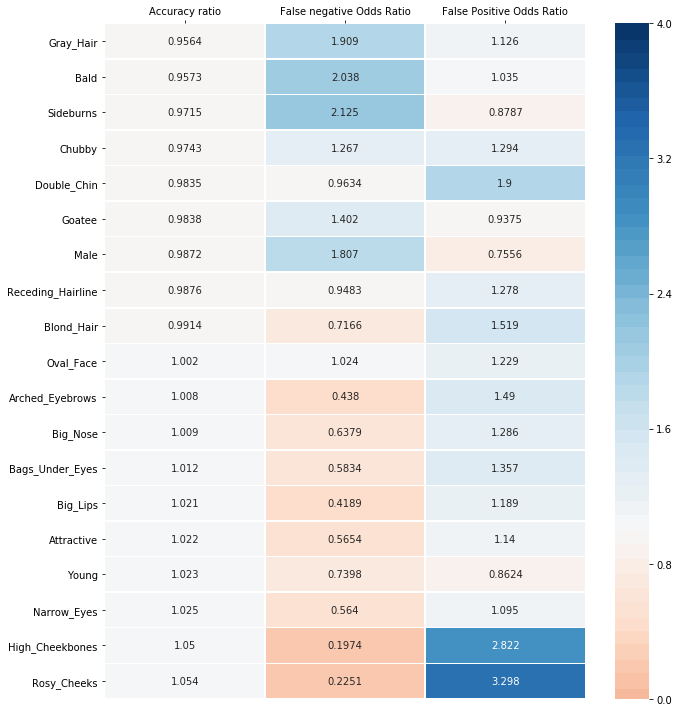

In [24]:
plt.figure(figsize = (10,10))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=4, cmap=cmap,annot=True, linewidths=.5, fmt='.4g')
ax = sns.heatmap(df_att2[['acc_ratio','FN_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['Accuracy ratio','False negative Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att2.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig(model+'.png',dpi=500)

In [25]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    pred_label = torch.max(get_labels(sample_batched), 1)[1]
    
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        #print(bias[i])
        print('Output of NN: ',output['out'][i])
        print('Predicted label: ', pred_label[i])

In [ ]:
batch_valid

In [ ]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\images_resize\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [ ]:
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        ac = accuracy(output['out'],labels_argmax)
        print(ac)

In [ ]:
output

In [ ]:
batch_valid